##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load images with tf.data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial provides a simple example of how to load an image dataset using `tf.data`.

The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.10.0'

In [2]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

AttributeError: module 'tensorflow.data' has no attribute 'experimental'

## Download and inspect the dataset

### Retrieve the images

Before you start any training, you'll need a set of images to teach the network about the new classes you want to recognize. You've created an archive of creative-commons licensed flower photos to use initially.

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file('flower_photos',
                                         'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 47s 0us/step
/Users/jessedecker/.keras/datasets/flower_photos


After downloading 218MB, you should now have a copy of the flower photos available:

In [4]:
for item in data_root.iterdir():
  print(item)

/Users/jessedecker/.keras/datasets/flower_photos/roses
/Users/jessedecker/.keras/datasets/flower_photos/sunflowers
/Users/jessedecker/.keras/datasets/flower_photos/daisy
/Users/jessedecker/.keras/datasets/flower_photos/dandelion
/Users/jessedecker/.keras/datasets/flower_photos/tulips
/Users/jessedecker/.keras/datasets/flower_photos/LICENSE.txt


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['/Users/jessedecker/.keras/datasets/flower_photos/roses/3630246240_4fee9a33db.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/dandelion/5605093210_5fecb71c61.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/dandelion/15987457_49dc11bf4b.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/roses/850416050_31b3ff7086.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/dandelion/2319777940_0cc5476b0d_n.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/roses/14166797345_d2ab9da518.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/tulips/18245124970_e68fd3f3c3.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/tulips/2503489175_f0848d3e8e.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/tulips/14674071872_2df55466d5_m.jpg',
 '/Users/jessedecker/.keras/datasets/flower_photos/daisy/9244082319_b1f7e2d8b0_n.jpg']

### Inspect the images
Now let's have a quick look at a couple of the images, so you know what you're dealing with:

In [7]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])


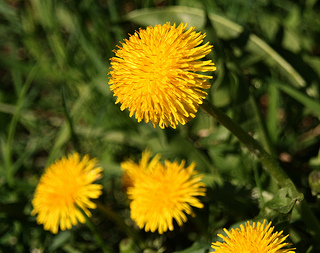

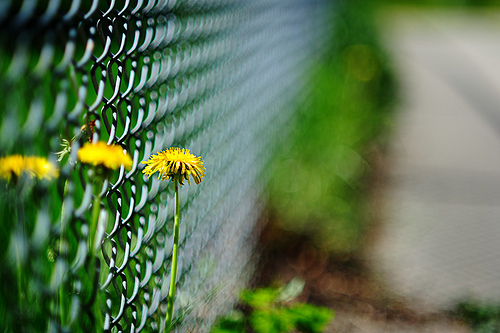

Image (CC BY 2.0)  by Blondinrikard Fröberg

Image (CC BY 2.0)  by kaybee07



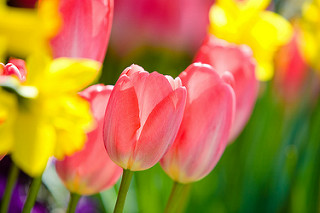

Image (CC BY 2.0)  by Kenny Louie



In [10]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

### Determine the label for each image

List the available labels:

In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Assign an index to each label:

In [12]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Create a list of every file, and its label index

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [2, 1, 1, 2, 1, 2, 4, 4, 4, 0]


### Load and format the images

TensorFlow includes all the tools you need to load and process images:

In [14]:
img_path = all_image_paths[0]
img_path

'/Users/jessedecker/.keras/datasets/flower_photos/roses/3630246240_4fee9a33db.jpg'

here is the raw data:

In [15]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=2, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\...


Decode it into an image tensor:

In [19]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


In [24]:
img_final = tf.image.resize_images(
    img_tensor,
    [192, 192],
    align_corners=False,
    preserve_aspect_ratio=False,
)

In [25]:
img_final

<tf.Tensor: id=41, shape=(192, 192, 3), dtype=float32, numpy=
array([[[ 2.        ,  2.        ,  0.        ],
        [ 1.        ,  1.        ,  0.        ],
        [ 2.        ,  2.        ,  0.        ],
        ...,
        [ 9.        , 12.        ,  1.        ],
        [10.        , 12.        ,  1.        ],
        [ 9.        , 12.6041565 ,  0.3958435 ]],

       [[ 1.        ,  1.        ,  0.        ],
        [ 1.        ,  1.        ,  0.        ],
        [ 1.2102864 ,  1.2102864 ,  0.        ],
        ...,
        [ 8.137695  , 12.137695  ,  0.        ],
        [ 9.        , 12.46875   ,  0.        ],
        [ 8.        , 11.894854  ,  0.        ]],

       [[ 1.46875   ,  1.46875   ,  0.        ],
        [ 0.7167969 ,  0.7167969 ,  0.        ],
        [ 1.0976564 ,  1.0976564 ,  0.        ],
        ...,
        [ 9.        , 13.        ,  0.        ],
        [ 8.628897  , 12.628897  ,  0.        ],
        [ 9.        , 13.        ,  0.        ]],

       ...,

Resize it for your model:

In [26]:
# img_final = tf.image.resize(img_tensor, [192, 192])



img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
1.0


Wrap up these up in simple functions for later.

In [29]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    img_final = tf.image.resize_images(
        img_tensor,
        [192, 192],
        align_corners=False,
        preserve_aspect_ratio=False,
    )
    image /= 255.0  # normalize to [0,1] range

    return image

In [30]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [31]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

## Build a `tf.data.Dataset`

### A dataset of images

The easiest way to build a `tf.data.Dataset` is using the `from_tensor_slices` method.

Slicing the array of strings results in a dataset of strings:

In [32]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

The `output_shapes` and `output_types` fields describe the content of each item in the dataset. In this case it is a set of scalar binary-strings

In [33]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<TensorSliceDataset shapes: (), types: tf.string>


Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [34]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

NameError: name 'AUTOTUNE' is not defined

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

NameError: name 'image_ds' is not defined

<Figure size 576x576 with 0 Axes>

### A dataset of `(image, label)` pairs

Using the same `from_tensor_slices` method you can build a dataset of labels

In [36]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [37]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

roses
dandelion
dandelion
roses
dandelion
roses
tulips
tulips
tulips
daisy


Since the datasets are in the same order you can just zip them together to get a dataset of `(image, label)` pairs.

In [38]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

NameError: name 'image_ds' is not defined

The new dataset's `shapes` and `types` are tuples of shapes and types as well, describing each field:

In [39]:
print(image_label_ds)

NameError: name 'image_label_ds' is not defined

Note: When you have arrays like `all_image_labels` and `all_image_paths`, an alternative to using `tf.data.dataset.Dataset.zip` is slicing the pair of arrays.

In [40]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

TypeError: unsupported operand type(s) for /=: 'Tensor' and 'float'

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* To repeat forever.
* To have batches available as soon as possible.

These features can be easily added using the `tf.data` api.

In [41]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

NameError: name 'image_label_ds' is not defined

There are a few things to note here:

1. The order is important.

  * A `.shuffle` *after* a `.repeat` would shuffle items across epoch boundaries (some items will be seen twice before others are seen at all).
  * A `.shuffle` *after* a `.batch` would shuffle the order of the batches, but not shuffle the items across batches.

1. Use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.

1. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.

1. The shuffled dataset doesn't report the end of a dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat`, causing another wait for the shuffle-buffer to be filled.

This last point, as well as the order of `.shuffle` and `.repeat`, can be addressed by using the `tf.data.Dataset.apply` method with the fused `tf.data.experimental.shuffle_and_repeat` function:

In [ ]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

  * For more on ordering the operations, see [Repeat and Shuffle](https://www.tensorflow.org/guide/performance/datasets#repeat_and_shuffle) in the Input Pipeline Performance guide.

### Pipe the dataset to a model

Fetch a copy of MobileNet v2 from `tf.keras.applications`.

This will be used for a simple transfer learning example.

Set the MobileNet weights to be non-trainable:

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

This model expects its input to be normalized to the `[-1,1]` range:

```
help(keras_applications.mobilenet_v2.preprocess_input)
```

<pre>
...
This function applies the "Inception" preprocessing which converts
the RGB values from [0, 255] to [-1, 1]
...
</pre>

So before passing data to the MobileNet model, you need to convert the input from a range of `[0,1]` to `[-1,1]`.

In [ ]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

The MobileNet returns a `6x6` spatial grid of features for each image.

Pass it a batch of images to see:

In [ ]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [ ]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

Because of this output shape, build a model wrapped around MobileNet using `tf.keras.layers.GlobalAveragePooling2D` to average over the space dimensions before the output `tf.keras.layers.Dense` layer:

In [ ]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

Now it produces outputs of the expected shape:

In [ ]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

Compile the model to describe the training procedure:

In [ ]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

There are 2 trainable variables: the Dense `weights` and `bias`:

In [ ]:
len(model.trainable_variables)

In [ ]:
model.summary()

Train the model.

Normally you would specify the real number of steps per epoch, but for demonstration purposes only run 3 steps.

In [ ]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

In [ ]:
model.fit(ds, epochs=1, steps_per_epoch=3)

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](https://www.tensorflow.org/guide/performance/datasets).

The simple pipeline used above reads each file individually, on each epoch. This is fine for local training on CPU but may not be sufficient for GPU training, and is totally inappropriate for any sort of distributed training.

To investigate, first build a simple function to check the performance of our datasets:

In [ ]:
import time

def timeit(ds, batches=2*steps_per_epoch+1):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(batches+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(batches, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(end-overall_start))

The performance of the current dataset is:

In [ ]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

In [ ]:
timeit(ds)

### Cache

Use `tf.data.Dataset.cache` to easily cache calculations across epochs. This is especially performant if the data fits in memory.

Here the images are cached, after being pre-precessed (decoded and resized):

In [ ]:
ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

In [ ]:
timeit(ds)

One disadvantage to using an in-memory cache is that the cache must be rebuilt on each run, giving the same startup delay each time the dataset is started:

In [ ]:
timeit(ds)

If the data doesn't fit in memory, use a cache file:

In [ ]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

In [ ]:
timeit(ds)

The cache file also has the advantage that it can be used to quickly restart the dataset without rebuilding the cache. Note how much faster it is the second time:

In [ ]:
timeit(ds)

### TFRecord File

#### Raw image data

TFRecord files are a simple format for storing a sequence of binary blobs. By packing multiple examples into the same file, TensorFlow is able to read multiple examples at once, which is especially important for performance when using a remote storage service such as GCS.

First, build a TFRecord file from the raw image data:

In [ ]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

Next build a dataset that reads from the TFRecord file and decodes/reformats the images using the `preprocess_image` function you defined earlier.

In [ ]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

Zip that with the labels dataset you defined earlier, to get the expected `(image,label)` pairs.

In [ ]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

In [ ]:
timeit(ds)

This is slower than the `cache` version because you have not cached the preprocessing.

#### Serialized Tensors

To save some preprocessing to the TFRecord file, first make a dataset of the processed images, as before:

In [ ]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

Now instead of a dataset of `.jpeg` strings, this is a dataset of tensors.

To serialize this to a TFRecord file you first convert the dataset of tensors to a dataset of strings.

In [ ]:
ds = image_ds.map(tf.serialize_tensor)
ds

In [ ]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

With the preprocessing cached, data can be loaded from the TFRecord file quite efficiently. Just remember to de-serialize the tensor before trying to use it.

In [ ]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
  result = tf.parse_tensor(x, out_type=tf.float32)
  result = tf.reshape(result, [192, 192, 3])
  return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

Now, add the labels and apply the same standard operations as before:

In [ ]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

In [ ]:
timeit(ds)